In [1]:
import tensorflow as tf
from spektral.models import GeneralGNN


class GNNCASimple(tf.keras.Model):
    """
    GNCA that uses You et al.'s GeneralGNN (with a single MP stage) to update the state.
    """

    def __init__(
        self,
        activation=None,
        message_passing=1,
        batch_norm=False,
        hidden=256,
        hidden_activation="relu",
        connectivity="cat",
        aggregate="sum",
        **kwargs
    ):
        super().__init__(**kwargs)
        self.activation = activation
        self.message_passing = message_passing
        self.batch_norm = batch_norm
        self.hidden = hidden
        self.hidden_activation = hidden_activation
        self.connectivity = connectivity
        self.aggregate = aggregate

    def build(self, input_shape):
        self.mp = GeneralGNN(
            input_shape[0][-1],
            activation=self.activation,
            message_passing=self.message_passing,
            pool=None,
            batch_norm=self.batch_norm,
            hidden=self.hidden,
            hidden_activation=self.hidden_activation,
            connectivity=self.connectivity,
            aggregate=self.aggregate,
        )

    def call(self, inputs):
        x = self.mp(inputs)
        return x

    @tf.function
    def steps(self, inputs, steps, **kwargs):
        x, a = inputs
        for _ in tf.range(steps):
            x = self([x, a], **kwargs)

        return x

2022-07-25 20:00:01.694164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
model = GNNCASimple(activation="tanh", batch_norm=False)

2022-07-25 20:00:03.794424: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-25 20:00:03.795687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-25 20:00:03.821229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:00:03.821346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro T1000 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2022-07-25 20:00:03.821366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-25 20:00:03.837161: I tensorflow/stream_executor/platform/default/dso_l

In [3]:
"""
Trains the GNCA to converge to a target point cloud.
"""
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.ndimage import gaussian_filter1d
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.transforms import NormalizeSphere
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [4]:
import pygsp
from spektral.data import Graph


def get_cloud(name, **kwargs):
    graph_class = getattr(pygsp.graphs, name)
    graph = graph_class(**kwargs)

    y = graph.coords
    a = graph.W.astype("f4")

    output = Graph(x=y, a=a)
    output.name = name

    return output

In [5]:
graph = get_cloud("Grid2d", N1=20, N2=20)

In [6]:
graph = NormalizeSphere()(graph)

In [7]:
# Unpack data
y = graph.x
a = sp_matrix_to_sp_tensor(graph.a)


In [8]:
a

In [9]:
y.shape

(400, 2)

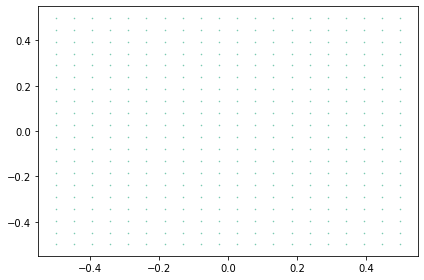

In [10]:
cmap = plt.get_cmap("Set2")
plt.scatter(*y[:, :2].T, color=cmap(0), marker=".", s=1)
plt.tight_layout()

In [27]:
np.array(graph.a)

array(<400x400 sparse matrix of type '<class 'numpy.float32'>'
	with 1520 stored elements in List of Lists format>, dtype=object)

In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())a
Data(edge_index=[2, 4], x=[3, 1])

/home/shyam/anaconda3/envs/growing_nn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: /home/shyam/anaconda3/envs/growing_nn/lib/python3.9/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [1]:
from growing_nn.nca import NCA2D

In [3]:
import torch
import numpy as np

In [ ]:
nca = NCA2D()